In [1]:
import os, sys, time
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import transforms

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = 6, 4

sns.set(rc={"figure.figsize": (6, 4)})
# sns.set(style="darkgrid")

print("Numpy version:", np.version.version)

# Set working dir to project root
while not os.getcwd().endswith("lmc"):
    os.chdir(os.pardir)

Numpy version: 1.23.5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import random

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Training / testing loops

In [4]:
from IPython.display import clear_output
from typing import Sequence

from src.modules import Indexer, IndexedModel

def train_epoch(model, optimizer, scheduler = None):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in trainloader:
        data = x_batch.to(device)
        target = y_batch.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion_train(output, target)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        with torch.no_grad():
            pred = torch.max(output, 1)[1]
    #         target = torch.max(target, 1)[1]
            acc = (pred == target).cpu().numpy().mean()
            acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

def test(model, dataloader):
    loss_log, acc_log = [], []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            output = model(data)
            loss = criterion_test(output, target)

            pred = torch.max(output, 1)[1].cpu().numpy()
            acc = np.mean(pred == target.cpu().numpy())
            acc_log.append(acc)

            loss = loss.item()
            loss_log.append(loss)
    return np.mean(loss_log), np.mean(acc_log)

def plot_history(train_history, val_history, title="loss"):
    plt.figure()
    plt.title("{}".format(title))
    plt.plot(train_history, label="train", zorder=1)
    
    points = np.array(val_history)
    
    plt.scatter(points[:, 0], points[:, 1], marker="+", s=180, c="orange", label="val", zorder=2)
    plt.xlabel("train steps")
    
    plt.legend(loc="best")
    plt.grid()

    plt.show()
    
def train(n_epochs, model, opt, scheduler = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt, scheduler)

        val_loss, val_acc = test(model, validloader)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(trainset) / batch_size
        val_log.append((steps * (epoch + 1), val_loss))
        val_acc_log.append((steps * (epoch + 1), val_acc))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title="accuracy")
        print("Epoch {} valid accuracy = {:.2%}".format(epoch, val_acc_log[-1][1]))
            
    evaluate(model)

def evaluate(model):
    print("Accuracy: {:.2%}".format(test(model, testloader)[1]))

def collect_statistics(models: Sequence[IndexedModel], full: bool = False):
    if full:
        untracked_keys = set()
        for model in models:
            for key, module in model.modules.items():
                if not module.track_activations:
                    untracked_keys.add(key)
                    module.track_activations = True
    
    for model in models:
        model.eval()
        model.reset_statistics()
        model.start_tracking()
    with torch.no_grad():
        for x_batch, _ in activation_loader:
            data = x_batch.to(device)
            for model in models:
                model(data)
    
    for model in models:
        model.stop_tracking()
    
    if full:
        for key in untracked_keys:
            for model in models:
                model[key].track_activations = False

## Models

In [5]:
from src.models import ConvNetDepth, convnet_permutation_spec

## Permutation methods

### Permutation utils

In [6]:
from src.utils import set_random_seed, interpolate, Timer
from src.rebasin import match_activations, match_weights, match_weights_sinkhorn, \
    repair, repair_closed, repair_sphere, repair_trainmode

### Sinkhorn direct (Mid, Rnd)

In [7]:
from src.modules import IndexedModel
from src.models import SinkhornRebasinModel
from src.permutation_specs import PermutationSpec, \
    apply_permutation

def sinkhorn_direct(model0: IndexedModel, model1: IndexedModel,
                    permutation_spec: PermutationSpec,
                    mode: str = "random", repair: str = "none",
                    max_iter: int = 20, sinkhorn_iter: int = 20,
                    sinkhorn_tau: float = 1.0, seed: int = 42):
    if seed is not None:
        set_random_seed(seed)

    model0.requires_grad(False)
    model1.requires_grad(False)
    model0.eval()
    model1.eval()
    device = model0[permutation_spec.perm2axes[0][0].key].device
    perm_sizes = [model0[axes[0].key].shape[axes[0].axis]
                  for axes in permutation_spec.perm2axes]
    
    rebasin_model = SinkhornRebasinModel(permutation_spec, perm_sizes,
                                         sinkhorn_iter, sinkhorn_tau,
                                         init="random")
    rebasin_model.to(device)
    optimizer = torch.optim.AdamW(rebasin_model.parameters(), lr=0.1)
    
    for iteration in range(max_iter):
        # Training
        rebasin_model.train()  # This uses soft permutation matrices
        train_loss = 0
        for x_batch, y_batch in trainloader:
            data = x_batch.to(device)
            target = y_batch.to(device)

            optimizer.zero_grad()
            permuted_model0 = rebasin_model(model0)
            if mode == "random":
                alpha = np.random.rand()
            else:
                alpha = 0.5
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
            
            output = interpolated(data)

            loss = criterion_train(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            del permuted_model0
        train_loss /= len(trainloader)

        # Validation
        rebasin_model.eval()  # This uses hard permutation matrices
        with torch.no_grad():
            permuted_model0 = rebasin_model(model0)
            interpolated = interpolate(permuted_model0, model1, alpha, copy=False)
            
            if repair == "closed":
                repair_closed(permuted_model0, model1, interpolated, alpha)
            elif repair == "trainmode":
                repair_trainmode(interpolated)
            elif repair == "sphere":
                repair_sphere(permuted_model0, model1, interpolated, alpha)
        valid_loss = test(interpolated, validloader)[0]
        del permuted_model0
        
        print(
            "Iteration {:02d}: training loss {:1.3f}, validation loss {:1.3f}".format(
                iteration, train_loss, valid_loss
            )
        )
        if valid_loss == 0:
            break
    
    permutations = rebasin_model.estimate_permutations()
    apply_permutation(model0, permutation_spec, permutations)

## Train two models

In [8]:
checkpoint_dir = "resources/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

data_dir = "/home/sergej/data"
os.makedirs(data_dir, exist_ok=True)

### CIFAR10

In [9]:
import torch.nn.functional as F

class MixupCrossEntropyLoss(nn.Module):
    def forward(self, input, target):
        logged_input = F.log_softmax(input, dim=-1)
        loss = -(target * logged_input).sum() / input.shape[0]
        return loss

def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.1
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

In [10]:
from src.augmentations import MixupWrapper, CutoutWrapper, CombineWrapper, SmoothOHEWrapper

# p = 0.5
# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.RandomApply([
#         transforms.ColorJitter(brightness=.5, hue=.1)
#     ], p=p),
#     transforms.RandomApply([
#         transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 5))
#     ], p=p),
#     transforms.RandomApply([
#         gauss_noise_tensor
#     ], p=p),
#     transforms.RandomApply([
#         transforms.RandomRotation((-15, 15), interpolation=transforms.InterpolationMode.BILINEAR)
#     ], p=p),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

train_transform = transforms.Compose([
#     transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 128
subset_size = 50 * batch_size

trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=train_transform)
# trainset, validset = torch.utils.data.random_split(trainset, [45000, 5000],
#                                                    generator=torch.Generator().manual_seed(42))
# trainset = SmoothOHEWrapper(
#     CombineWrapper(
#         MixupWrapper(trainset, alpha=0.8, p=0.5),
#         CutoutWrapper(trainset, size=10, p=0.5)
#     ),
#     n_classes=10
# )
trainset = CutoutWrapper(trainset, size=10, p=0.25)
activation_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False,
                                       download=True, transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
activation_loader = torch.utils.data.DataLoader(activation_subset, batch_size=batch_size,
                                                shuffle=False)
validloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

criterion_train = nn.CrossEntropyLoss()  # MixupCrossEntropyLoss()
criterion_test = nn.CrossEntropyLoss()

device = "cuda:0"

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from dataclasses import dataclass

@dataclass
class CIFARConvNetConfig:
    init_channels = 64
    num_classes = 10
    max_depth = 3
    matching_mode = "post_activation"

config = CIFARConvNetConfig()

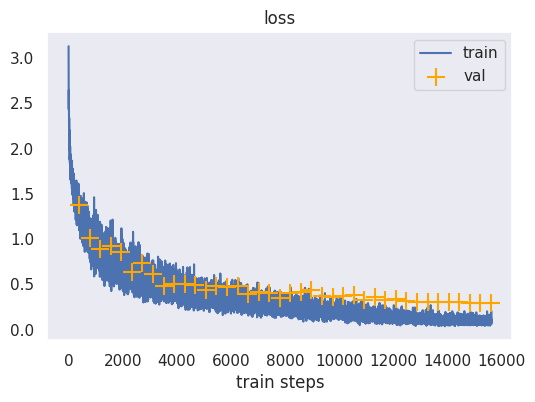

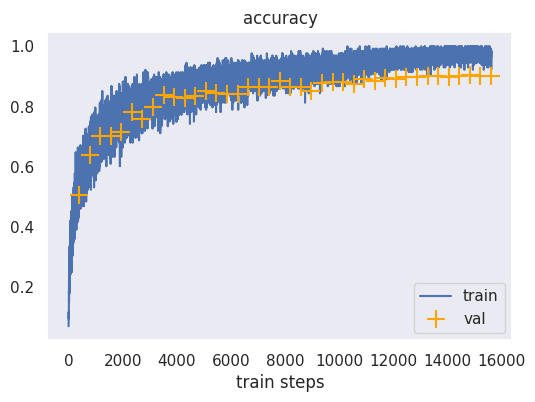

Epoch 39 valid accuracy = 90.12%
Accuracy: 90.12%


In [16]:
set_random_seed(42)

lr = 1e-2
num_epochs = 40

model0 = ConvNetDepth(config)
model0.to(device)
optim = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model0, optim, scheduler)
torch.save(model0.state_dict(), checkpoint_dir + "/cifar_conv_augb0.pth")

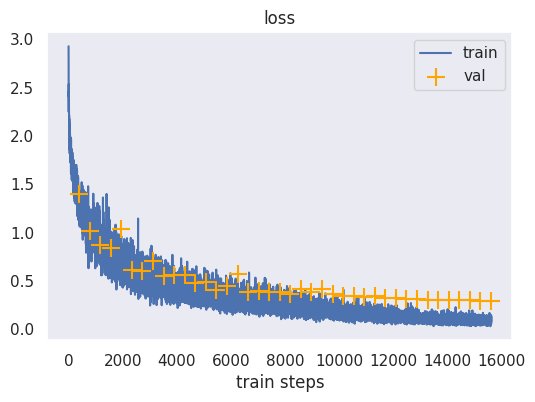

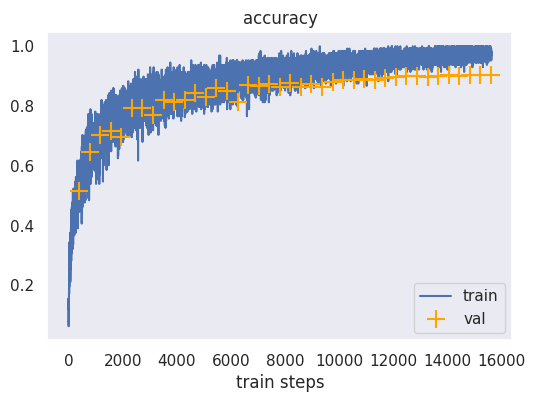

Epoch 39 valid accuracy = 90.36%
Accuracy: 90.36%


In [17]:
set_random_seed(92)

lr = 1e-2
num_epochs = 40

model1 = ConvNetDepth(config)
model1.to(device)
optim = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

train(num_epochs, model1, optim, scheduler)
torch.save(model1.state_dict(), checkpoint_dir + "/cifar_conv_augb1.pth")

## Permute the weights of model 0 to align with model 1

In [12]:
from tqdm.auto import tqdm

def get_interpolation(model0, model1, alphas = np.linspace(0, 1, 25),
                      repair = "none", loader = None):
    if loader is None:
        loader = testloader
    
    accuracies = []
    losses = []
    for alpha in tqdm(alphas, desc="Interpolate"):
        interpolated = interpolate(model0, model1, alpha)
        if repair == "closed":
            repair_closed(model0, model1, interpolated, alpha)
        elif repair == "trainmode":
            repair_trainmode(interpolated)
        elif repair == "sphere":
            repair_sphere(model0, model1, interpolated, alpha)
        loss, accuracy = test(interpolated, loader)
        accuracies += [accuracy]
        losses += [loss]
        
        del interpolated

    return accuracies, losses, alphas

def get_variance(model):
    return np.array([
        module.var.mean().item() for module in model.modules.values()
    ], dtype=float)

def reload_models():
    global model0, model1
    
    model0 = ConvNetDepth(config)
    model0.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_{model_type}0.pth"))
    model1 = ConvNetDepth(config)
    model1.load_state_dict(torch.load(checkpoint_dir + f"/{dataset_name}_{model_type}1.pth"))

    model0.to(device)
    model1.to(device)

### CIFAR10

### ConvNet

In [13]:
config = CIFARConvNetConfig()
perm_spec = convnet_permutation_spec(config)
dataset_name = "cifar"
model_type = "conv_augb"
save_name = "cifar10_convnet_no_bias"

In [ ]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")
# accs_sph, losses_sph, _ = get_interpolation(model0, model1, repair="sphere")
# collect_statistics([model0, model1], full=True)
# accs_rep, losses_rep, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

reload_models()
collect_statistics([model0, model1], full=True)
match_activations(model0, model1, perm_spec)
# post_act_accs, post_act_losses, _ = get_interpolation(model0, model1)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# post_act_sph_accs, post_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# post_act_rep_accs, post_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

reload_models()
match_weights(model0, model1, perm_spec, normalize=False)
# weight_accs, weight_losses, _ = get_interpolation(model0, model1)
weight_tr_accs, weight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# weight_sph_accs, weight_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# collect_statistics([model0, model1], full=True)
# weight_rep_accs, weight_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

# reload_models()
# match_weights(model0, model1, perm_spec, normalize=True)
# weightn_tr_accs, weightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

# del model0
# del model1

# config.matching_mode = "pre_activation"
# reload_models()
# collect_statistics([model0, model1], full=True)
# match_activations(model0, model1, perm_spec)
# pre_act_accs, pre_act_losses, _ = get_interpolation(model0, model1)
# pre_act_tr_accs, pre_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# pre_act_sph_accs, pre_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
# pre_act_rep_accs, pre_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

# del model0
# del model1

reload_models()
match_weights_sinkhorn(model0, model1, perm_spec, normalize=False)
# sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

# reload_models()
# match_weights_sinkhorn(model0, model1, perm_spec, normalize=True)
# sweightn_accs, sweightn_losses, _ = get_interpolation(model0, model1)
# sweightn_tr_accs, sweightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

# del model0
# del model1

Direct

In [15]:
reload_models()
sinkhorn_direct(model0, model1, perm_spec, repair="trainmode")
# sweight_accs, sweight_losses, _ = get_interpolation(model0, model1)
sdirect_tr_accs, sdirect_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

Iteration 00: training loss 0.458, validation loss 0.344
Iteration 01: training loss 0.214, validation loss 0.459
Iteration 02: training loss 0.216, validation loss 0.411
Iteration 03: training loss 0.217, validation loss 0.545
Iteration 04: training loss 0.213, validation loss 0.432
Iteration 05: training loss 0.213, validation loss 0.329
Iteration 06: training loss 0.212, validation loss 0.556
Iteration 07: training loss 0.226, validation loss 0.331
Iteration 08: training loss 0.225, validation loss 0.328
Iteration 09: training loss 0.232, validation loss 0.334
Iteration 10: training loss 0.222, validation loss 0.328
Iteration 11: training loss 0.238, validation loss 0.405
Iteration 12: training loss 0.229, validation loss 0.332
Iteration 13: training loss 0.252, validation loss 0.541
Iteration 14: training loss 0.239, validation loss 0.374
Iteration 15: training loss 0.247, validation loss 0.418
Iteration 16: training loss 0.245, validation loss 0.432
Iteration 17: training loss 0.2

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

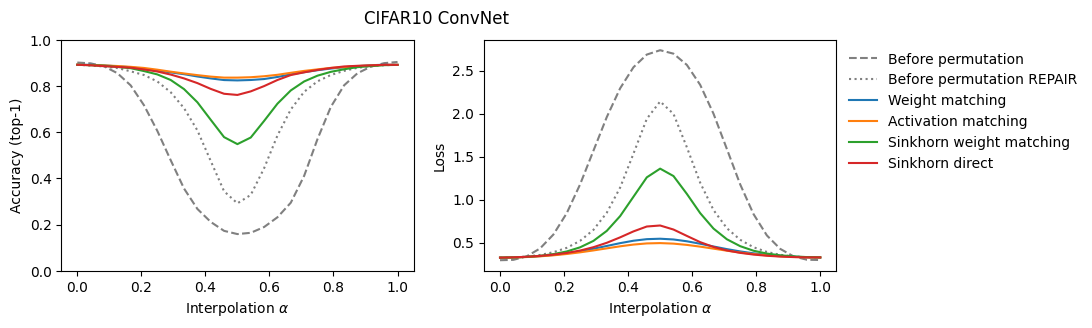

In [16]:
sns.reset_orig()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(alphas, accs, label="Before permutation", linestyle="--", color="grey")
axes[0].plot(alphas, accs_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[0].plot(alphas, weight_tr_accs, label="Weight matching")
axes[0].plot(alphas, post_act_tr_accs, label="Activation matching")
axes[0].plot(alphas, sweight_tr_accs, label="Sinkhorn weight matching")
axes[0].plot(alphas, sdirect_tr_accs, label="Sinkhorn direct")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Interpolation $\\alpha$")
axes[0].set_ylabel("Accuracy (top-1)")
# axes[0].legend(bbox_to_anchor=(1, 1), frameon=False)

axes[1].plot(alphas, losses, label="Before permutation", linestyle="--", color="grey")
axes[1].plot(alphas, losses_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[1].plot(alphas, weight_tr_losses, label="Weight matching")
axes[1].plot(alphas, post_act_tr_losses, label="Activation matching")
axes[1].plot(alphas, sweight_tr_losses, label="Sinkhorn weight matching")
axes[1].plot(alphas, sdirect_tr_losses, label="Sinkhorn direct")
axes[1].set_xlabel("Interpolation $\\alpha$")
axes[1].set_ylabel("Loss")
axes[1].legend(bbox_to_anchor=(1, 1), frameon=False)

plt.suptitle("CIFAR10 ConvNet")
plt.savefig(f"pics/new_{save_name}.pdf", bbox_inches="tight")
plt.show()

In [16]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")
# accs_sph, losses_sph, _ = get_interpolation(model0, model1, repair="sphere")
accs_tr_sph, losses_tr_sph, _ = get_interpolation(model0, model1, repair="sphere")
collect_statistics([model0, model1], full=True)
accs_rep, losses_rep, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

reload_models()
collect_statistics([model0, model1], full=True)
match_activations(model0, model1, perm_spec)
post_act_accs, post_act_losses, _ = get_interpolation(model0, model1)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
# post_act_sph_accs, post_act_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
post_act_tr_sph_accs, post_act_tr_sph_losses, _ = get_interpolation(model0, model1, repair="sphere")
post_act_rep_accs, post_act_rep_losses, _ = get_interpolation(model0, model1, repair="closed")

del model0
del model1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

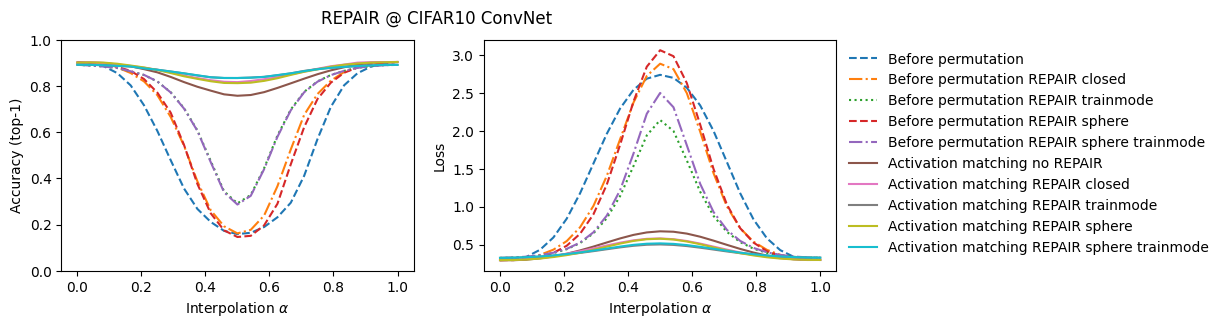

In [17]:
sns.reset_orig()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(alphas, accs, label="Before permutation", linestyle="--")
axes[0].plot(alphas, accs_rep, label="Before permutation REPAIR closed", linestyle="-.")
axes[0].plot(alphas, accs_tr, label="Before permutation REPAIR trainmode", linestyle=":")
axes[0].plot(alphas, accs_sph, label="Before permutation REPAIR sphere", linestyle="--")
axes[0].plot(alphas, accs_tr_sph, label="Before permutation REPAIR sphere trainmode", linestyle="-.")
axes[0].plot(alphas, post_act_accs, label="Activation matching no REPAIR")
axes[0].plot(alphas, post_act_rep_accs, label="Activation matching REPAIR closed")
axes[0].plot(alphas, post_act_tr_accs, label="Activation matching REPAIR trainmode")
axes[0].plot(alphas, post_act_sph_accs, label="Activation matching REPAIR sphere")
axes[0].plot(alphas, post_act_tr_sph_accs, label="Activation matching REPAIR sphere trainmode")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Interpolation $\\alpha$")
axes[0].set_ylabel("Accuracy (top-1)")
# axes[0].legend(bbox_to_anchor=(1, 1), frameon=False)

axes[1].plot(alphas, losses, label="Before permutation", linestyle="--")
axes[1].plot(alphas, losses_rep, label="Before permutation REPAIR closed", linestyle="-.")
axes[1].plot(alphas, losses_tr, label="Before permutation REPAIR trainmode", linestyle=":")
axes[1].plot(alphas, losses_sph, label="Before permutation REPAIR sphere", linestyle="--")
axes[1].plot(alphas, losses_tr_sph, label="Before permutation REPAIR sphere trainmode", linestyle="-.")
axes[1].plot(alphas, post_act_losses, label="Activation matching no REPAIR")
axes[1].plot(alphas, post_act_rep_losses, label="Activation matching REPAIR closed")
axes[1].plot(alphas, post_act_tr_losses, label="Activation matching REPAIR trainmode")
axes[1].plot(alphas, post_act_sph_losses, label="Activation matching REPAIR sphere")
axes[1].plot(alphas, post_act_tr_sph_losses, label="Activation matching REPAIR sphere trainmode")
axes[1].set_xlabel("Interpolation $\\alpha$")
axes[1].set_ylabel("Loss")
axes[1].legend(bbox_to_anchor=(1, 1), frameon=False)

plt.suptitle("REPAIR @ CIFAR10 ConvNet")
plt.savefig(f"pics/new_{save_name}_repair_ns.pdf", bbox_inches="tight")
plt.show()

In [23]:
reload_models()
collect_statistics([model0, model1], full=True)
orig_var = get_variance(model0)

match_activations(model0, model1, perm_spec)

interpolated = interpolate(model0, model1)
collect_statistics([interpolated], full=True)
rel_var = get_variance(interpolated) / orig_var

repair_trainmode(interpolated)

collect_statistics([interpolated], full=True)
rep_var = get_variance(interpolated) / orig_var

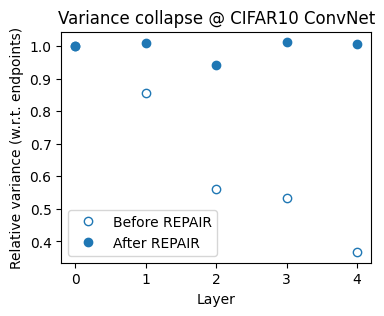

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3))
plt.plot([1] + rel_var[1::2].tolist(), label="Before REPAIR", marker="o", linestyle="none",
         markerfacecolor="none", color=sns.color_palette()[0])
plt.plot([1] + rep_var[1::2].tolist(), label="After REPAIR", marker="o", linestyle="none",
         color=sns.color_palette()[0])
plt.xticks(ticks=[0, 1, 2, 3, 4])
plt.xlabel("Layer")
plt.ylabel("Relative variance (w.r.t. endpoints)")
plt.legend()
plt.title("Variance collapse @ CIFAR10 ConvNet")
plt.savefig(f"pics/new_{save_name}_variance.pdf", bbox_inches="tight")
plt.show()

In [17]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
collect_statistics([model0, model1], full=True)
match_activations(model0, model1, perm_spec)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

config.matching_mode = "pre_activation"
reload_models()
collect_statistics([model0, model1], full=True)
match_activations(model0, model1, perm_spec)
pre_act_tr_accs, pre_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")
config.matching_mode = "post_activation"

del model0
del model1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

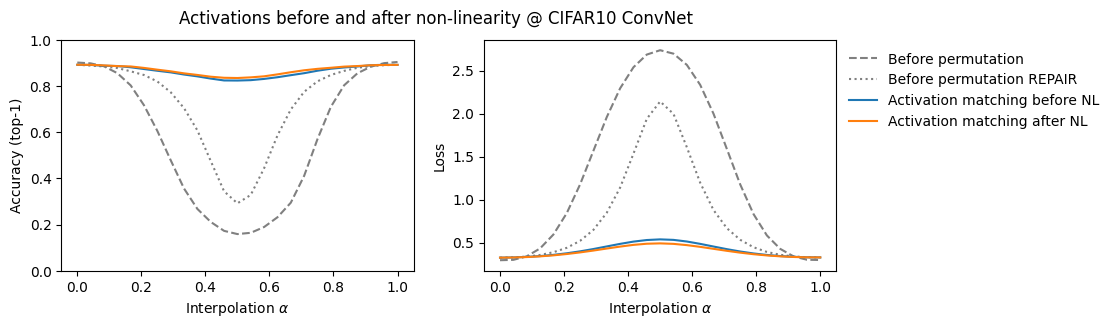

In [18]:
sns.reset_orig()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(alphas, accs, label="Before permutation", linestyle="--", color="grey")
axes[0].plot(alphas, accs_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[0].plot(alphas, pre_act_tr_accs, label="Activation matching before NL")
axes[0].plot(alphas, post_act_tr_accs, label="Activation matching after NL")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Interpolation $\\alpha$")
axes[0].set_ylabel("Accuracy (top-1)")
# axes[0].legend(bbox_to_anchor=(1, 1), frameon=False)

axes[1].plot(alphas, losses, label="Before permutation", linestyle="--", color="grey")
axes[1].plot(alphas, losses_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[1].plot(alphas, pre_act_tr_losses, label="Activation matching before NL")
axes[1].plot(alphas, post_act_tr_losses, label="Activation matching after NL")
axes[1].set_xlabel("Interpolation $\\alpha$")
axes[1].set_ylabel("Loss")
axes[1].legend(bbox_to_anchor=(1, 1), frameon=False)

plt.suptitle("Activations before and after non-linearity @ CIFAR10 ConvNet")
plt.savefig(f"pics/new_{save_name}_before_after.pdf", bbox_inches="tight")
plt.show()

In [17]:
reload_models()
accs, losses, alphas = get_interpolation(model0, model1)
accs_tr, losses_tr, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
collect_statistics([model0, model1], full=True)
match_activations(model0, model1, perm_spec)
post_act_tr_accs, post_act_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
match_weights(model0, model1, perm_spec, normalize=False)
weight_tr_accs, weight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
match_weights(model0, model1, perm_spec, normalize=True)
weightn_tr_accs, weightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
match_weights_sinkhorn(model0, model1, perm_spec, normalize=False)
sweight_tr_accs, sweight_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

reload_models()
match_weights_sinkhorn(model0, model1, perm_spec, normalize=True)
sweightn_tr_accs, sweightn_tr_losses, _ = get_interpolation(model0, model1, repair="trainmode")

del model0
del model1

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

Iteration 00: training loss 0.047, validation loss 0.068
Iteration 01: training loss 0.046, validation loss 0.068
Iteration 02: training loss 0.044, validation loss 0.068
Iteration 03: training loss 0.043, validation loss 0.068
Iteration 04: training loss 0.042, validation loss 0.065
Iteration 05: training loss 0.041, validation loss 0.057
Iteration 06: training loss 0.039, validation loss 0.053
Iteration 07: training loss 0.038, validation loss 0.051
Iteration 08: training loss 0.038, validation loss 0.050
Iteration 09: training loss 0.037, validation loss 0.049
Iteration 10: training loss 0.036, validation loss 0.048
Iteration 11: training loss 0.035, validation loss 0.047
Iteration 12: training loss 0.035, validation loss 0.046
Iteration 13: training loss 0.034, validation loss 0.045
Iteration 14: training loss 0.033, validation loss 0.045
Iteration 15: training loss 0.033, validation loss 0.044
Iteration 16: training loss 0.032, validation loss 0.043
Iteration 17: training loss 0.0

Interpolate:   0%|          | 0/25 [00:00<?, ?it/s]

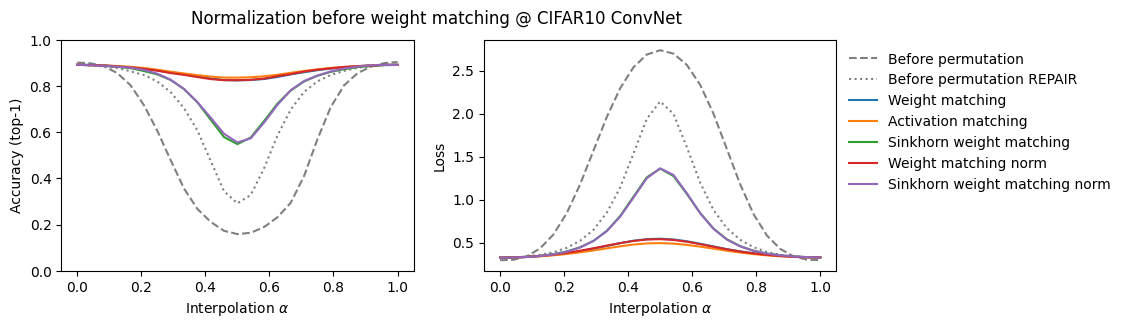

In [18]:
sns.reset_orig()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(alphas, accs, label="Before permutation", linestyle="--", color="grey")
axes[0].plot(alphas, accs_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[0].plot(alphas, weight_tr_accs, label="Weight matching")
axes[0].plot(alphas, post_act_tr_accs, label="Activation matching")
axes[0].plot(alphas, sweight_tr_accs, label="Sinkhorn weight matching")
axes[0].plot(alphas, weightn_tr_accs, label="Weight matching norm")
axes[0].plot(alphas, sweightn_tr_accs, label="Sinkhorn weight matching norm")
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Interpolation $\\alpha$")
axes[0].set_ylabel("Accuracy (top-1)")
# axes[0].legend(bbox_to_anchor=(1, 1), frameon=False)

axes[1].plot(alphas, losses, label="Before permutation", linestyle="--", color="grey")
axes[1].plot(alphas, losses_tr, label="Before permutation REPAIR", linestyle=":", color="grey")
axes[1].plot(alphas, weight_tr_losses, label="Weight matching")
axes[1].plot(alphas, post_act_tr_losses, label="Activation matching")
axes[1].plot(alphas, sweight_tr_losses, label="Sinkhorn weight matching")
axes[1].plot(alphas, weightn_tr_losses, label="Weight matching norm")
axes[1].plot(alphas, sweightn_tr_losses, label="Sinkhorn weight matching norm")
axes[1].set_xlabel("Interpolation $\\alpha$")
axes[1].set_ylabel("Loss")
axes[1].legend(bbox_to_anchor=(1, 1), frameon=False)

plt.suptitle("Normalization before weight matching @ CIFAR10 ConvNet")
plt.savefig(f"pics/new_{save_name}_weight_norm.pdf", bbox_inches="tight")
plt.show()

In [18]:
from copy import deepcopy

def activation_entry(model0, model1):
    collect_statistics([model0, model1], full=True)
    match_activations(model0, model1, perm_spec)

def weight_entry(model0, model1):
    match_weights(model0, model1, perm_spec, normalize=False, seed=None)

def weight_norm_entry(model0, model1):
    match_weights(model0, model1, perm_spec, normalize=True, seed=None)

def add_entry(matching, name, epoch, model0, model1, result):
    matching(model0, model1)
    interpolated = interpolate(model0, model1)
    repair_trainmode(interpolated)
    loss, accuracy = test(interpolated, testloader)
    return concat_to_result(epoch, name, accuracy, loss, result)
    del interpolated
    del model0
    del model1

def concat_to_result(epoch, name, accuracy, loss, result):
    tmp_data = {"Epoch": epoch,
                "Method": name,
                "Accuracy": accuracy,
                "Loss": loss}
    return pd.concat([result, pd.DataFrame(index=[0], data=tmp_data)], ignore_index=True)

def collect_by_epoch(n_epochs, model0, model1, opt0, opt1, scheduler0 = None, scheduler1 = None):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    
    result = pd.DataFrame()

    for epoch in range(n_epochs + 1):
        print("Epoch {} of {}".format(epoch, n_epochs))
        if epoch > 0:
            train_loss0, train_acc0 = train_epoch(model0, opt0, scheduler0)
            train_loss1, train_acc1 = train_epoch(model1, opt1, scheduler1)
        else:
            train_loss0, train_acc0 = [], []
        
        result = add_entry(activation_entry, "Activation matching", epoch,
                           deepcopy(model0), deepcopy(model1), result)
        result = add_entry(weight_entry, "Weight matching", epoch,
                           deepcopy(model0), deepcopy(model1), result)
        result = add_entry(weight_norm_entry, "Weight matching norm", epoch,
                           deepcopy(model0), deepcopy(model1), result)

        val_loss0, val_acc0 = test(model0, validloader)
        result = concat_to_result(epoch, "Model A", val_acc0, val_loss0, result)

        val_loss1, val_acc1 = test(model1, validloader)
        result = concat_to_result(epoch, "Model B", val_acc1, val_loss1, result)

        train_log.extend(train_loss0)
        train_acc_log.extend(train_acc0)

        steps = len(trainset) / batch_size
        val_log.append((steps * epoch, val_loss0))
        val_acc_log.append((steps * epoch, val_acc0))

        clear_output()
        plot_history(train_log, val_log)    
        plot_history(train_acc_log, val_acc_log, title="accuracy")
        print("Epoch {} valid accuracy = {:.2%}".format(epoch, val_acc_log[-1][1]))
    
    result.to_csv(f"resources/output/{save_name}.csv")
    return result

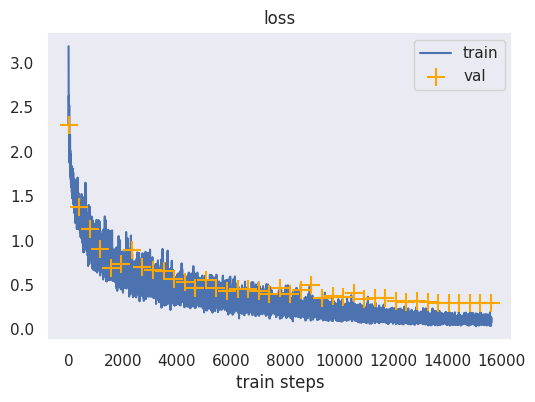

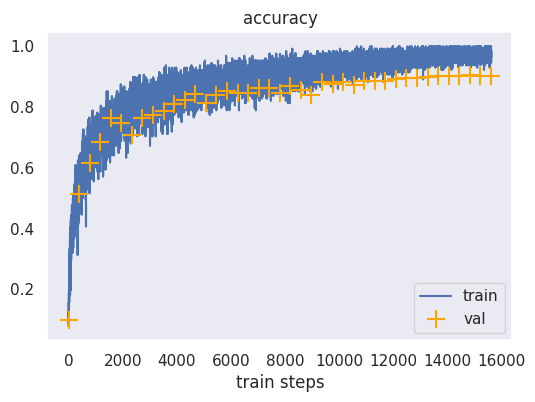

Epoch 40 valid accuracy = 90.29%


In [19]:
set_random_seed(42)

lr = 1e-2
num_epochs = 40

model0 = ConvNetDepth(config)
model0.to(device)
optim0 = torch.optim.SGD(model0.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler0 = torch.optim.lr_scheduler.OneCycleLR(optim0, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

model1 = ConvNetDepth(config)
model1.to(device)
optim1 = torch.optim.SGD(model1.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optim1, **{
    "steps_per_epoch": len(trainloader),
    "epochs": num_epochs,
    "anneal_strategy": "cos",
    "max_lr": lr,
    "pct_start": 0.1
})

result = collect_by_epoch(num_epochs, model0, model1, optim0, optim1, scheduler0, scheduler1)

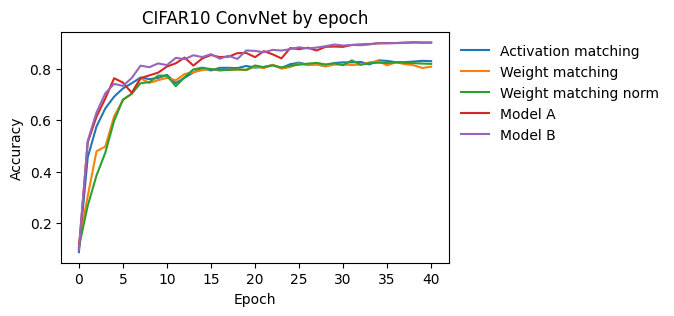

In [14]:
result = pd.read_csv(f"resources/output/{save_name}.csv")

sns.reset_orig()
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(x="Epoch", y="Accuracy", hue="Method", data=result)
plt.legend(bbox_to_anchor=(1, 1), frameon=False)
plt.title("CIFAR10 ConvNet by epoch")
plt.savefig(f"pics/new_{save_name}_acc_by_epoch.pdf", bbox_inches="tight")

plt.show()

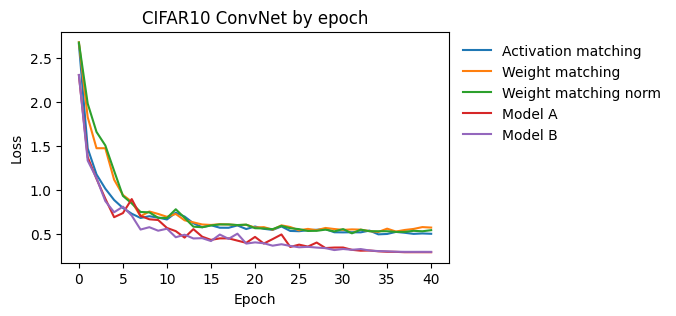

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(5, 3))
sns.lineplot(x="Epoch", y="Loss", hue="Method", data=result)
plt.legend(bbox_to_anchor=(1.58, 1), frameon=False)
plt.title("CIFAR10 ConvNet by epoch")
plt.savefig(f"pics/new_{save_name}_loss_by_epoch.pdf", bbox_inches="tight")

plt.show()